# Plotting Kernel Priors

In [1]:
import math
import torch
import gpflow
from matplotlib import pyplot as plt
import numpy as np

2022-09-26 14:05:35.865589: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
def get_observations(exp_name="circle", n_observations=8):
    """
    Get observations for the bean or circle experiment
    """
    u = v = yu = yv = None
    if exp_name not in ["bean", "circle"]:
        print("Currently only bean and circle experiments are supported")
        return u, v, yu, yv

    if exp_name == "circle":
        u = 0.5 * np.cos(np.linspace(-np.pi, np.pi, n_observations))
        v = 0.5 * np.sin(np.linspace(-np.pi, np.pi, n_observations))

        yu = np.sin(np.linspace(-np.pi, np.pi, n_observations))
        yv = -np.cos(np.linspace(-np.pi, np.pi, n_observations))

    elif exp_name == "bean":
        a = 1
        th = np.linspace(0, np.pi, 63).T
        r = a * np.sin(th) ** 3 + a * np.cos(th) ** 3
        u = r * np.cos(th) - 0.3
        v = r * np.sin(th) - 0.3

        yu = np.diff(u)
        yv = np.diff(v)

        n = 63//n_observations

        u = u[::n]
        v = v[::n]

        yu = yu[::n] * 10
        yv = yv[::n] * 10

    return u, v, yu, yv

In [3]:
x_cr, y_cr, u_cr, v_cr = get_observations("circle", 10)

circle_pnts = np.concatenate((x_cr.reshape((-1,1)), y_cr.reshape((-1, 1))), axis=1)

y_labels = np.concatenate((u_cr.reshape((-1,1)), v_cr.reshape((-1,1))), axis=1)
data = (circle_pnts, y_labels)

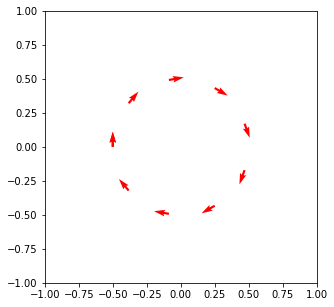

In [4]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.set_aspect("equal", adjustable="box")

plt.quiver(x_cr, y_cr, u_cr, v_cr, color="red", width=0.008)

plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

## Divergence Free Kernel

## Model 

In [5]:
import gpytorch
from model.core.kernels import DivergenceFreeKernel, RBF

In [6]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = DivergenceFreeKernel(train_x.shape[1], train_y.shape[1])

    def forward(self, x):
        mean_x = self.mean_module(x) #*torch.eye(x.shape[0])
        covar_x = self.covar_module(x)
        print(mean_x.shape)
        print(covar_x.shape)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


In [7]:
x = np.linspace(-1, 1, 20)
y = np.linspace(-1, 1, 20)
xx, yy = np.meshgrid(x, y)
zz = np.hstack((xx.reshape(-1, 1), yy.reshape(-1, 1)))

In [8]:
train_x = torch.from_numpy(circle_pnts)
train_y = torch.from_numpy(y_labels)
test_z = torch.from_numpy(zz)

In [9]:
k_lengthscale = 0.2
k_variance = 0.1

In [11]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(train_x, train_y, likelihood)

In [13]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

f_predict()
p(F* | Y)

In [39]:
P =train_x.shape[1]
N = train_x.shape[0]
M = test_z.shape[0]
R = test_z.shape[1]

dim = N * P
dim_new_data = M * R

In [33]:
kmm = model.covar_module(train_x)
knn = model.covar_module(test_z, full_output_cov=True)
kmn = model.covar_module(train_x, test_z, full_output_cov=True)  # Change

In [34]:
dim = N * P
kmm = torch.reshape(kmm, (dim, dim))
knn = torch.reshape(knn, (dim_new_data, dim_new_data))
kmn = torch.reshape(kmn, (dim, dim_new_data))

In [36]:
num_data = P * N  # Change
s = torch.eye(num_data)*0.1 #tf.linalg.diag(tf.fill([num_data], self.likelihood.variance))

In [42]:
# Change
X_data_t = train_x.repeat(P,1)
X_data_t = torch.reshape(X_data_t, (dim, -1))
Y_data_t = torch.reshape(train_y, (dim, -1))

In [44]:
err = Y_data_t

TO BE IMPLEMENTED CONDITIONAL 

f_mean_zero, f_var = conditional(
            kmn, kmm + s, knn, err, full_cov=True, white=False
        )

In [37]:
Lm = torch.linalg.cholesky(kmm+s)

In [49]:
kmn.shape

torch.Size([20, 800])

In [50]:
torch.range(1, K - 1)

/tmp/ipykernel_2350166/4271767458.py:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  torch.range(1, K - 1)


tensor([1.])

In [45]:
#compute kernel stuff
num_func = err.shape[-1]  # R
N = kmn.shape[-1]
M = err.shape[-2]

# get the leading dims in Kmn to the front of the tensor
# if Kmn has rank two, i.e. [M, N], this is the identity op.
K = len(list(kmn.shape))
perm = torch.concat(
    [
        torch.reshape(torch.range(1, K - 1), [K - 2]),  # leading dims (...)
        torch.reshape(0, [1]),  # [M]
        torch.reshape(K - 1, [1]),
    ],
    0,
)  # [N]
Kmn = torch.permute(kmn, perm)  # [..., M, N]

leading_dims = kmn.shape[:-2]

/tmp/ipykernel_2350166/3837505624.py:11: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  torch.reshape(torch.range(1, K - 1), [K - 2]),  # leading dims (...)


RuntimeError: shape '[0]' is invalid for input of size 1

In [ ]:
#https://github.com/GPflow/GPflow/blob/develop/gpflow/conditionals/util.py
# https://github.com/GPflow/GPflow/blob/60afe7a8e8f6daf46ef787c707c8cb9a9aca1118/gpflow/conditionals/util.py#L84

#compute kernel stuff
num_func = err.shape[-1]  # R
N = kmn.shape[-1]
M = err.shape[-2]

# get the leading dims in Kmn to the front of the tensor
# if Kmn has rank two, i.e. [M, N], this is the identity op.
K = len(list(kmn.shape))
perm = torch.concat(
    [
        torch.reshape(torch.range(1, K - 1), [K - 2]),  # leading dims (...)
        torch.reshape(0, [1]),  # [M]
        torch.reshape(K - 1, [1]),
    ],
    0,
)  # [N]
Kmn = torch.permute(kmn, perm)  # [..., M, N]

leading_dims = kmn.shape[:-2]

# Compute the projection matrix A
Lm = tf.broadcast_to(Lm, tf.concat([leading_dims, tf.shape(Lm)], 0))  # [..., M, M]
A = tf.linalg.triangular_solve(Lm, Kmn, lower=True)  # [..., M, N]

# compute the covariance due to the conditioning
fvar = Knn - tf.linalg.matmul(A, A, transpose_a=True)  # [..., N, N]
cov_shape = tf.concat([leading_dims, [num_func, N, N]], 0)
fvar = tf.broadcast_to(tf.expand_dims(fvar, -3), cov_shape)  # [..., R, N, N]

# another backsubstitution in the unwhitened case
if not white:
    A = tf.linalg.triangular_solve(tf.linalg.adjoint(Lm), A, lower=False)

# construct the conditional mean
f_shape = tf.concat([leading_dims, [M, num_func]], 0)  # [..., M, R]
f = tf.broadcast_to(f, f_shape)  # [..., M, R]
fmean = tf.linalg.matmul(A, f, transpose_a=True)  # [..., N, R]


In [27]:
def get_trajectory_euler(initial_state, v_model, n_trajectories=100, end_state_t=50, dt=1.0):
    previous_state = np.repeat(
        np.array(initial_state, dtype=np.float64).reshape((1, 2)),
        n_trajectories,
        axis=0,
    )

    all_paths = previous_state
    all_paths = all_paths.reshape((-1, 1, 2))

    n_states = int(end_state_t / dt)

    mvn = np.random.multivariate_normal
    for s in range(1, n_states):
        pred_m, pred_S = v_model.build_conditional(previous_state)
        pred_m = pred_m.reshape(previous_state.shape)
        
        x_pred_m = pred_m[:, 0]
        y_pred_m = pred_m[:, 1]
        x_pred_S = pred_S[:, 0]
        y_pred_S = pred_S[:, 1]

        x_pred_covar = np.diag(x_pred_S.reshape(-1))
        y_pred_covar = np.diag(y_pred_S.reshape(-1))

        x_pred = mvn(x_pred_m.reshape(-1), x_pred_covar, 1).reshape(n_trajectories)
        y_pred = mvn(y_pred_m.reshape(-1), y_pred_covar, 1).reshape(n_trajectories)

        previous_state = previous_state + dt * np.stack(
            (x_pred, y_pred), axis=1
        ).reshape(-1, 2)
    
        all_paths = np.hstack((all_paths, previous_state.reshape((-1, 1, 2))))

    return all_paths

In [ ]:
initial_state = [-0.6, 0.0]
end_t = 15
dt = 0.01
n_trajectories = 10

In [ ]:
df_predicted_trajectories = get_trajectory_euler(
        initial_state, df_model, n_trajectories=n_trajectories, end_state_t=end_t, dt=dt
    )